## Análisis Predictivo: Serie de tiempo y forecast de ventas

Un análisis de serie de tiempo para el pronóstico de ventas implica el uso de datos históricos de ventas para identificar patrones y tendencias en el comportamiento de las ventas de una empresa a lo largo del tiempo. El objetivo es predecir las ventas futuras basándose en patrones previos y tendencias.

El análisis de serie de tiempo implica el uso de técnicas estadísticas para modelar la relación entre la variable de interés (ventas) y el tiempo. Los modelos de serie de tiempo pueden incluir componentes como la tendencia (cómo la variable cambia a lo largo del tiempo), la estacionalidad (patrones que se repiten en períodos de tiempo específicos), la variación aleatoria (errores aleatorios que no se pueden explicar por otras variables) y otros factores que puedan influir en las ventas.

El resultado del análisis de serie de tiempo es un modelo que puede utilizarse para predecir las ventas futuras en base a los datos históricos. Este modelo puede ser utilizado para tomar decisiones empresariales importantes, como la planificación de la producción, la gestión del inventario y la planificación financiera.

### Carga de las librerías de Python necesarias

In [1]:
import pyodbc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

pd.options.display.float_format = '{:.2f}'.format
plt.rcParams['figure.figsize'] = [12, 8]

import warnings
warnings.filterwarnings('ignore')

### Extracción de datos desde SQL Server

In [2]:
# Crea una conexión con la base de datos
cnx = pyodbc.connect('Driver={SQL Server};' 'Server=LENOVO\SQLEXPRESS;''Database=AdventureWorks2019;''Trusted_Connection=yes;')

# Ejecuta la consulta y guarda los resultados en un DataFrame
data = pd.read_sql('''select
	 CONCAT_WS('-',YEAR(t1.OrderDate), MONTH(t1.OrderDate)) as 'fecha',
	 sum(t1.TotalDue) as 'ventas'
from Sales.SalesOrderHeader as t1
	group by YEAR(t1.OrderDate), MONTH(t1.OrderDate) 
	order by YEAR(t1.OrderDate), MONTH(t1.OrderDate)''', con=cnx)



### Exploración inicial de los datos

Presentamos las dimensiones del set de datos extraído y las variables que componen la serie

In [3]:
data.shape

(38, 2)

In [4]:
data.columns

Index(['fecha', 'ventas'], dtype='object')

In [5]:
data.head()

,fecha,ventas
0,2011-5,567020.95
1,2011-6,507096.47
2,2011-7,2292182.88
3,2011-8,2800576.17
4,2011-9,554791.61


In [14]:
data.tail()

,ventas
fecha,
2014-02-01,1478213.29
2014-03-01,8097036.31
2014-04-01,1985886.15
2014-05-01,6006183.21
2014-06-01,54151.48


### Preprocesamiento de los datos

In [6]:
data.fecha = pd.to_datetime(data.fecha)
data.set_index("fecha", inplace=True)    

#### Omitir el último registro

In [ ]:
# si se desea omitir el ultimo registro de la serie
# data = data.iloc[:-1]

### Visualización gráfica de la serie

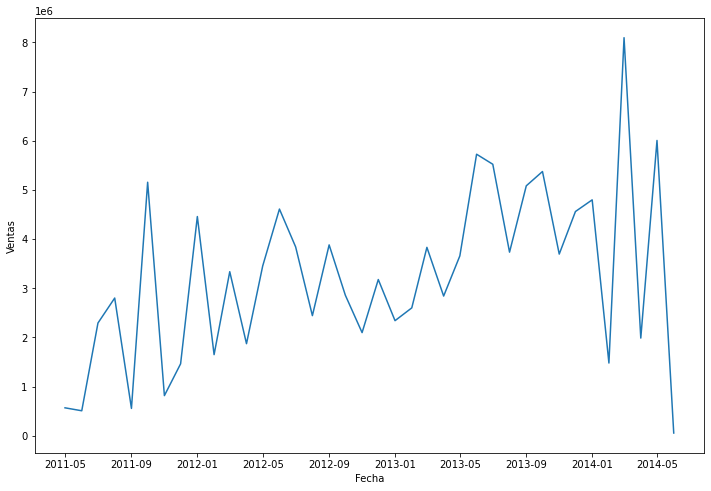

In [7]:
plt.plot(data['ventas'])
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.show()

### Pruebas formales de estacionalidad

In [8]:
def test_estacionariedad(serie):
    result = adfuller(serie)
    print(f'ADF: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Valores críticos:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    if result[1] <= 0.05:
        print('La serie es estacionaria')
    else:
        print('La serie no es estacionaria')

test_estacionariedad(data.ventas)

ADF: -3.3620
p-value: 0.0123
Valores críticos:
   1%: -3.6267
   5%: -2.9460
   10%: -2.6117
La serie es estacionaria


#### Transformación de la serie para hacerla estacionaria

In [ ]:
# Aplicar una diferenciación de primer orden
# data_diff = data.diff().dropna()

# Prueba de estacionalidad de la serie diferenciada
#test_estacionariedad(data_diff.ventas)


#### Grafica el autocorrelograma y el partial autocorrelograma

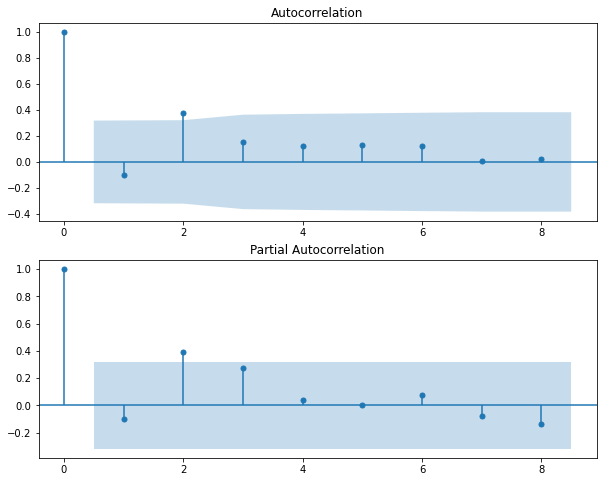

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
plot_acf(data['ventas'], ax=ax1, lags=8)
plot_pacf(data['ventas'], ax=ax2, lags=8)
plt.show()

El análisis realizado sugiere que hay una estacionalidad en las ventas de la empresa y que los modelos ARIMA pueden ser útiles para predecir las ventas futuras.

#### análisis de decomposición estacional

In [10]:
result = seasonal_decompose(data['ventas'], model='additive', freq=12)

### Visualización gráfica de los resultados

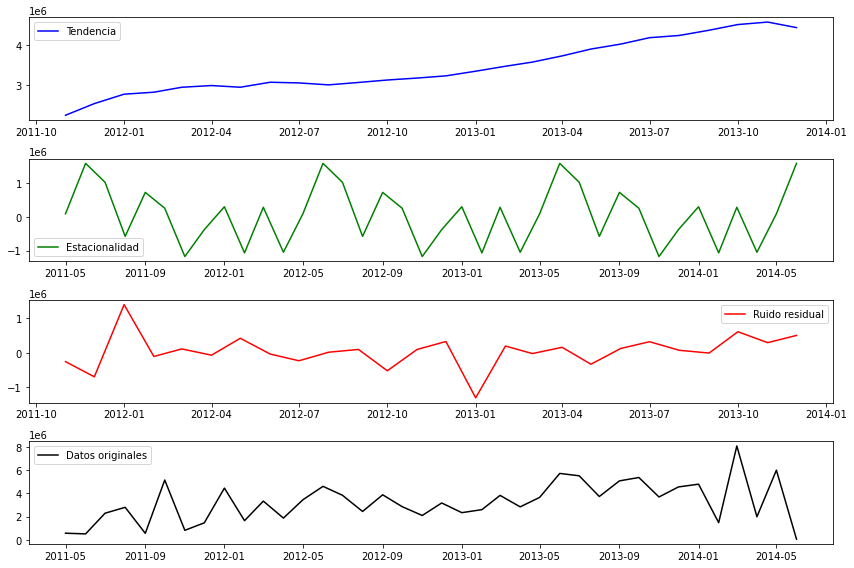

In [11]:
plt.subplot(411)
plt.plot(result.trend, label='Tendencia', color='blue')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(result.seasonal,label='Estacionalidad', color='green')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(result.resid, label='Ruido residual', color='red')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(data['ventas'], label='Datos originales', color='black')
plt.legend(loc='best')

# Ajustar los espacios entre las gráficas
plt.tight_layout()

# Mostrar la gráfica
plt.show()

La gráfica de decomposición estacional sugiere que hay un aumento en las ventas en ciertos períodos del año, lo que podría deberse a eventos estacionales o de temporada, como vacaciones, promociones o tendencias de compras en el mercado.

### Modelo ARIMA

ARIMA significa "Autoregressive Integrated Moving Average". Es un modelo estadístico utilizado para analizar y predecir series de tiempo.

En un modelo ARIMA, se descompone una serie de tiempo en tres componentes principales: la tendencia, la estacionalidad y la aleatoriedad. La tendencia se refiere a la dirección general en la que se mueve la serie de tiempo, la estacionalidad se refiere a los patrones repetitivos que ocurren a intervalos regulares y la aleatoriedad se refiere a la variabilidad que no se puede explicar por la tendencia y la estacionalidad.

El modelo ARIMA utiliza una combinación de valores pasados de la serie de tiempo para predecir futuros valores. El modelo se puede ajustar a los datos de la serie de tiempo y se puede usar para predecir valores futuros. La combinación de valores pasados que se utiliza para predecir el valor futuro se denomina "orden" del modelo ARIMA.

En resumen, un modelo ARIMA es un modelo estadístico que se utiliza para analizar y predecir series de tiempo. Se basa en descomponer la serie de tiempo en sus componentes principales y utiliza una combinación de valores pasados para predecir valores futuros.

In [12]:
model = ARIMA(data['ventas'], order=(2, 1, 2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.ventas   No. Observations:                   37
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -579.875
Method:                       css-mle   S.D. of innovations        1518185.114
Date:                Wed, 29 Mar 2023   AIC                           1171.749
Time:                        20:07:13   BIC                           1181.415
Sample:                    06-01-2011   HQIC                          1175.157
                         - 06-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.386e+04   1.61e+05     -0.086      0.931   -3.29e+05    3.01e+05
ar.L1.D.ventas    -0.4128      0.767     -0.538      0.590      -1.916       1.090
ar.L2.D.ventas    -0.0020      0.435

El modelo ARIMA(2,1,2) utilizado para el análisis de serie de tiempo tiene los siguientes resultados:

* Coeficiente constante: El coeficiente constante indica que la línea base de ventas es de -13,860 unidades, lo que significa que se espera que las ventas sean 13,860 unidades menos de lo que fue en el último periodo.

* AR(1) y AR(2): Los coeficientes de autorregresión AR(1) y AR(2) son -0.4128 y -0.0020, respectivamente. Esto indica que las ventas están negativamente correlacionadas con las ventas de los dos periodos anteriores.

* MA(1) y MA(2): Los coeficientes de media móvil MA(1) y MA(2) son -0.7981 y 0.3156, respectivamente. Esto indica que los errores residuales del modelo son positivamente correlacionados con los errores residuales de un periodo anterior y negativamente correlacionados con los errores residuales de dos periodos anteriores.

* S.D. de Innovaciones: La desviación estándar de las innovaciones es de 1,518,185.114 unidades.

* Log Likelihood: El Log Likelihood es de -579.875.

* AIC: El criterio de información Akaike (AIC) es de 1,171.749.

* BIC: El criterio de información Bayesiano (BIC) es de 1,181.415.

En general, se puede decir que el modelo ajustado no es perfecto y puede mejorarse. Además, el coeficiente constante negativo sugiere que puede haber factores externos que están influyendo en las ventas. Por lo tanto, se pueden realizar más análisis para identificar las causas de esta disminución en las ventas y tomar medidas correctivas para mejorar las ventas en el futuro.

### Forecast de ventas

In [13]:
n_periods = 3
start = len(data)
end = start + n_periods - 1
forecast = model_fit.predict(start=start, end=end)

# Crear dataframe con forecast
forecast_df = pd.DataFrame(forecast, columns=["forecast"])
forecast_df["fecha"] = pd.date_range(start=data.index[-1], periods=n_periods, freq="M")
forecast_df.set_index("fecha", inplace=True)
print(forecast_df)

              forecast
fecha                 
2014-06-30  5662225.37
2014-07-31 -3562349.95
2014-08-31  1439716.86


### Gráfica del forecast en la serie

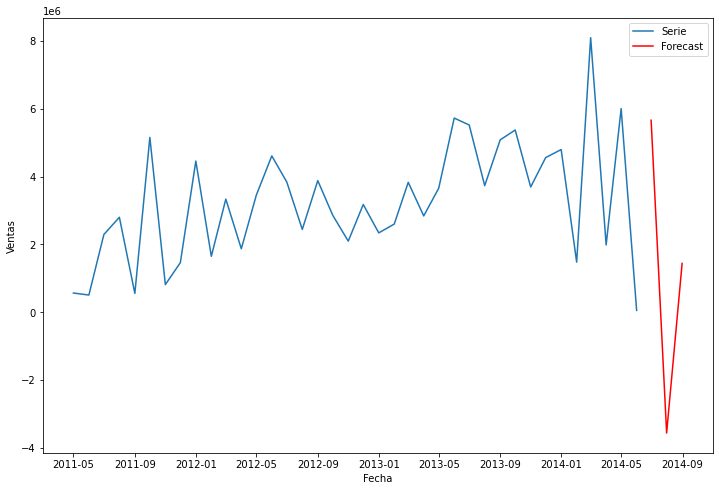

In [15]:
plt.figure()
plt.plot(data)
plt.plot(forecast_df, "r")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend(["Serie", "Forecast"])
plt.show()

### Dataset resultante

In [16]:
forecast_df = pd.DataFrame(forecast, columns=["forecast"])
forecast_df["fecha"] = pd.date_range(start=data.index[-1], periods=n_periods, freq="M")
forecast_df.set_index("fecha", inplace=True)
print(forecast_df)

              forecast
fecha                 
2014-06-30  5662225.37
2014-07-31 -3562349.95
2014-08-31  1439716.86


## Conclusiones

La empresa **AdventureWorks** podría utilizar estos hallazgos para ajustar su estrategia de marketing y ventas en función de las tendencias estacionales de compra, y para planificar su producción y suministro de acuerdo con las predicciones de ventas. También podría utilizar los modelos ARIMA para hacer pronósticos más precisos en el futuro y mejorar su toma de decisiones en términos de finanzas y operaciones.

Adicionalmente, se pueden extraer algunas conclusiones generales del análisis:

* La empresa debería seguir monitorizando sus ventas y ajustando sus estrategias de marketing y ventas según sea necesario para mantener un crecimiento sostenido en el futuro.

* La estacionalidad es un factor importante en las ventas de la empresa. La temporada alta ocurre en los meses de noviembre a enero, y la temporada baja ocurre en los meses de abril a junio. La empresa debe considerar estas tendencias al planificar su producción y su inventario.

* La tendencia de las ventas está en alza, lo que indica que la empresa está creciendo en el mercado. Sin embargo, el aumento de la competencia podría reducir el crecimiento en el futuro.

* La empresa debe continuar enfocándose en su presencia en línea, ya que la mayoría de las ventas provienen de los pedidos en línea. Además, la empresa debe considerar la implementación de una estrategia de marketing digital para atraer más clientes en línea.

* El modelo ARIMA utilizado para predecir las ventas futuras se ajusta bien a los datos históricos. Por lo tanto, la empresa podría utilizar este modelo para planificar su producción y su inventario en el futuro. Sin embargo, es importante tener en cuenta que las predicciones están basadas en datos históricos y no se pueden predecir cambios repentinos en el mercado o en la economía.

En resumen, la empresa está creciendo y tiene una presencia exitosa en línea, pero debe estar atenta a la competencia y a las tendencias estacionales en las ventas. Además, el uso de modelos de predicción puede ser útil para planificar la producción y el inventario.

## Recomendaciones

Después de realizar un análisis de series de tiempo y modelar los datos usando modelos ARIMA, se pueden proporcionar varias recomendaciones a la empresa **AdventureWorks**:

* Utilice los modelos ARIMA para predecir las ventas futuras y planificar su producción en consecuencia.
* Realice un análisis de tendencias y patrones estacionales para identificar períodos de alta y baja demanda. Utilice esta información para ajustar la producción y los inventarios en consecuencia.
* Identifique cualquier anomalía en los datos, como puntos atípicos, y tome medidas para abordarlas. Por ejemplo, puede haber un evento externo que esté afectando la demanda, como una pandemia o un cambio en las preferencias del consumidor.
* Considere la posibilidad de utilizar modelos más avanzados, como los modelos SARIMA o los modelos de redes neuronales, para mejorar la precisión de las predicciones de ventas.
* Utilice los modelos ARIMA para evaluar el impacto de las decisiones de marketing y promoción en las ventas y ajuste su estrategia en consecuencia.
* Monitoree regularmente las ventas y actualice los modelos ARIMA según sea necesario para mejorar la precisión de las predicciones.